In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from datetime import datetime, timedelta
import time

# 读取数据
# filename1 = "202408\\SPXOIData.txt"
filename = "202410\\SPXOIData.txt"
# filename = "202409\\SPXInterdayOIData.txt"
df = pd.read_csv(filename, sep=",")
df.columns = ['Time', 'Symbol', 'Strike', 'ExpiredDate', 'Right', 'Vol', 'OI', 'Gamma', 'DailyClose']
# df10= pd.read_csv(filename1, sep=",")
# df10.columns = ['Time', 'Symbol', 'Strike', 'ExpiredDate', 'Right', 'Vol', 'OI', 'Gamma', 'DailyClose']
# df= pd.concat([df, df10], ignore_index=True)
df['Time'] = df['Time'].astype(str).str.strip().str[0:8]
df['ExpiredDate'] = df['ExpiredDate'].astype(str).str.strip()
df['Right'] = df['Right'].astype(str).str.strip()
df['Strike'] = df['Strike'].astype(float)
df['DailyClose'] = df['DailyClose'].astype(float)
df['OI'] = df['OI'].astype(float)
# 将 'Time' 转换为日期时间格式
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d')
df['ExpiredDate1'] = pd.to_datetime(df['ExpiredDate'], format='%Y%m%d')

df['CallOI'] = np.where(df['Right'] == 'C', df['OI'], 0)
df['PutOI'] = np.where(df['Right'] == 'P', df['OI'], 0)
df['TotalOI'] = df['CallOI'] + df['PutOI']

df['CallVol'] = np.where(df['Right'] == 'C', df['Vol'], 0)
df['PutVol'] = np.where(df['Right'] == 'P', df['Vol'], 0)
df['TotalVol'] = df['CallVol'] + df['PutVol']

df['Put-Vol-OI'] = np.where(df['Right'] == 'P', df['Vol'] - df['OI'], 0)
df['Call-Vol-OI'] = np.where(df['Right'] == 'C', df['Vol'] - df['OI'], 0)

df['CallGEX'] = np.where(df['Right'] == 'C', df['Gamma'] * (df['OI']) * 100 * df['DailyClose'] * df['DailyClose'] * 0.01/10**9, 0)
df['PutGEX'] = np.where(df['Right'] == 'P', -df['Gamma'] * (df['OI']) * 100 * df['DailyClose'] * df['DailyClose'] * 0.01/10**9, 0)
df['TotalGEX'] = df['CallGEX'] + df['PutGEX']
# print(df)

In [63]:
fromStrike = 5600
toStrike = 5900
now = datetime.now()
start_time = pd.Timestamp(year=now.year, month=10, day=10, hour=0, minute=0)

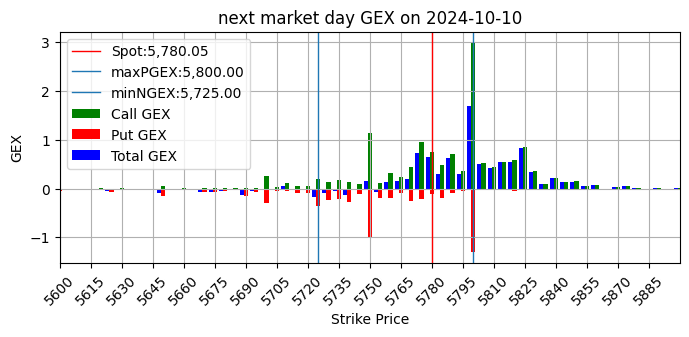

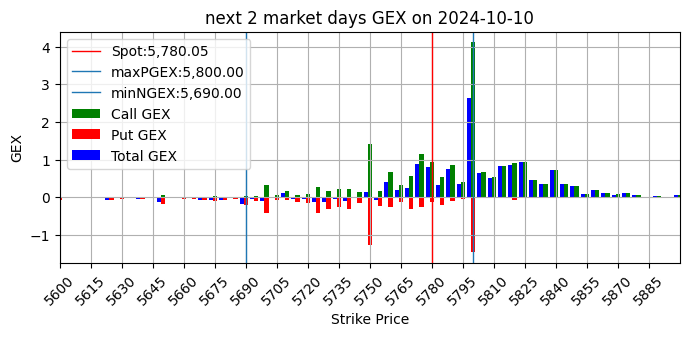

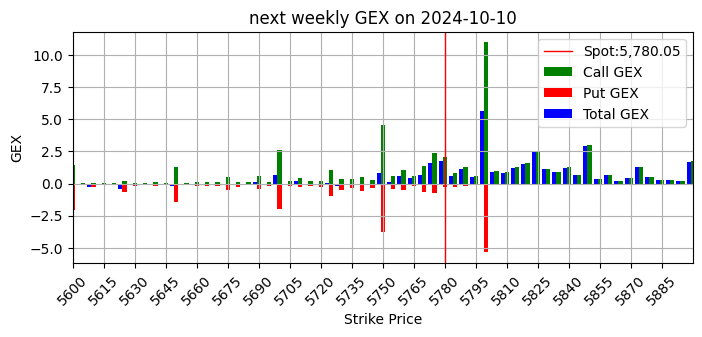

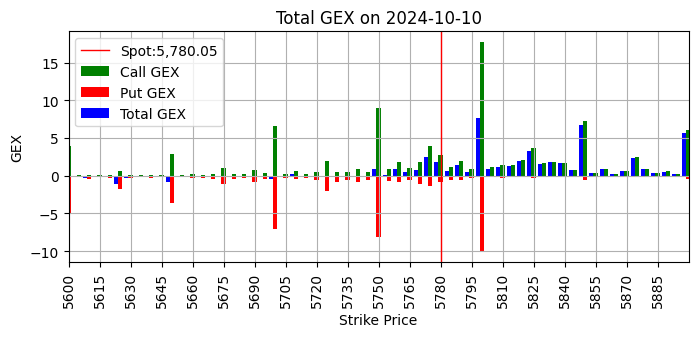

In [64]:
## GEX 柱状图

# time_minus_30 = now - timedelta(days=5)
# start_time = pd.Timestamp(year=time_minus_30.year, month=time_minus_30.month, day=time_minus_30.day, hour=0, minute=0)
# df2 = df[df['Time'] > start_time]


df2 = df[df['Time'] == start_time]
df2 = df2[df2['ExpiredDate1'] > start_time]
# print(df2)

## 下一个交易日
nextmarketday = pd.Timestamp(year=now.year, month=10, day=11, hour=0, minute=0)
df4= df2[df2['ExpiredDate1'] ==  nextmarketday]

df_agg2 = df4.groupby('Strike')[['CallGEX', 'PutGEX', 'TotalGEX']].sum().reset_index()
# df_agg2.iloc[df_agg2['TotalGEX'].abs().nlargest(1).index].copy()
maxPGEX = df_agg2.iloc[df_agg2['TotalGEX'].nlargest(1).index].copy()
minNGEX = df_agg2.iloc[df_agg2['TotalGEX'].nsmallest(1).index].copy()
# print(maxPGEX)
# 绘图
fig, ax = plt.subplots(figsize=(8, 3))
# print(df4.empty)
spotPrice = df4['DailyClose'].iloc[0]
ax.axvline(x=spotPrice, color='r', lw=1, label="Spot:" + str("{:,.2f}".format(spotPrice)))
ax.axvline(x=maxPGEX["Strike"].iloc[0], linestyle='-', lw=1, label="maxPGEX:"+str("{:,.2f}".format(maxPGEX["Strike"].iloc[0])))
ax.axvline(x=minNGEX["Strike"].iloc[0], linestyle='-', lw=1, label="minNGEX:"+str("{:,.2f}".format(minNGEX["Strike"].iloc[0])))
ax.bar(df_agg2['Strike'], df_agg2['CallGEX'], width=2, color='green', label='Call GEX')
ax.bar(df_agg2['Strike'], df_agg2['PutGEX'], width=2, color='red', label='Put GEX')
ax.bar(df_agg2['Strike']-2, df_agg2['TotalGEX'], width=2, color='blue', label='Total GEX')
# ax.bar(df_agg2['Strike'], df_agg2['TotalGEX'], width=4, color='blue', label='Total GEX')

plt.xlim([fromStrike, toStrike])
# 设置 x 轴刻度，每隔 10 个刻度显示一个刻度
plt.xticks(range(fromStrike, toStrike, 15))
ax.set_xlabel('Strike Price')
ax.set_ylabel('GEX')
ax.set_title(f'next market day GEX on {start_time.strftime("%Y-%m-%d")}')
ax.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 下2个交易日
nextmarketday = pd.Timestamp(year=now.year, month=10, day=14, hour=0, minute=0)
df4= df2[df2['ExpiredDate1'] <=  nextmarketday]

df_agg2 = df4.groupby('Strike')[['CallGEX', 'PutGEX', 'TotalGEX']].sum().reset_index()
# df_agg2.iloc[df_agg2['TotalGEX'].abs().nlargest(1).index].copy()
maxPGEX = df_agg2.iloc[df_agg2['TotalGEX'].nlargest(1).index].copy()
minNGEX = df_agg2.iloc[df_agg2['TotalGEX'].nsmallest(1).index].copy()
# print(maxPGEX)
# 绘图
fig, ax = plt.subplots(figsize=(8, 3))
# print(df4.empty)
spotPrice = df4['DailyClose'].iloc[0]
ax.axvline(x=spotPrice, color='r', lw=1, label="Spot:" + str("{:,.2f}".format(spotPrice)))
ax.axvline(x=maxPGEX["Strike"].iloc[0], linestyle='-', lw=1, label="maxPGEX:"+str("{:,.2f}".format(maxPGEX["Strike"].iloc[0])))
ax.axvline(x=minNGEX["Strike"].iloc[0], linestyle='-', lw=1, label="minNGEX:"+str("{:,.2f}".format(minNGEX["Strike"].iloc[0])))
ax.bar(df_agg2['Strike'], df_agg2['CallGEX'], width=2, color='green', label='Call GEX')
ax.bar(df_agg2['Strike'], df_agg2['PutGEX'], width=2, color='red', label='Put GEX')
ax.bar(df_agg2['Strike']-2, df_agg2['TotalGEX'], width=2, color='blue', label='Total GEX')
# ax.bar(df_agg2['Strike'], df_agg2['TotalGEX'], width=4, color='blue', label='Total GEX')

plt.xlim([fromStrike, toStrike])
# 设置 x 轴刻度，每隔 10 个刻度显示一个刻度
plt.xticks(range(fromStrike, toStrike, 15))
ax.set_xlabel('Strike Price')
ax.set_ylabel('GEX')
ax.set_title(f'next 2 market days GEX on {start_time.strftime("%Y-%m-%d")}')
ax.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 下一周的 GEX
nextweek = pd.Timestamp(year=now.year, month=10, day=19, hour=0, minute=0)
df3= df2[df2['ExpiredDate1'] <  nextweek]
# print(len(df3))    

df_agg2 = df3.groupby('Strike')[['CallGEX', 'PutGEX', 'TotalGEX']].sum().reset_index()
# 绘图
fig, ax = plt.subplots(figsize=(8, 3))
spotPrice = df3['DailyClose'].iloc[0]
ax.axvline(x=spotPrice, color='r', lw=1, label="Spot:" + str("{:,.2f}".format(spotPrice)))
ax.bar(df_agg2['Strike'], df_agg2['CallGEX'], width=2, color='green', label='Call GEX')
ax.bar(df_agg2['Strike'], df_agg2['PutGEX'], width=2, color='red', label='Put GEX')
ax.bar(df_agg2['Strike']-2, df_agg2['TotalGEX'], width=2, color='blue', label='Total GEX')

plt.xlim([fromStrike, toStrike])
# 设置 x 轴刻度，每隔 10 个刻度显示一个刻度
plt.xticks(range(fromStrike, toStrike, 15))
ax.set_xlabel('Strike Price')
ax.set_ylabel('GEX')
ax.set_title(f'next weekly GEX on {start_time.strftime("%Y-%m-%d")}')
ax.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Total GEX
fig, ax = plt.subplots(figsize=(8, 3))   

spotPrice = df3['DailyClose'].iloc[0]
ax.axvline(x=spotPrice, color='r', lw=1, label="Spot:" + str("{:,.2f}".format(spotPrice)))

df3 = df2
# print(len(df1))
df_agg1 = df3.groupby('Strike')[['CallGEX', 'PutGEX', 'TotalGEX']].sum().reset_index()

ax.bar(df_agg1['Strike'], df_agg1['CallGEX'], width=2, color='green', label='Call GEX')
ax.bar(df_agg1['Strike'], df_agg1['PutGEX'], width=2, color='red', label='Put GEX')
ax.bar(df_agg1['Strike']-2, df_agg1['TotalGEX'], width=2, color='blue', label='Total GEX')

plt.xlim([fromStrike, toStrike])
# 设置 x 轴刻度，每隔 10 个刻度显示一个刻度
plt.xticks(range(fromStrike, toStrike, 15))
ax.set_xlabel('Strike Price')
ax.set_ylabel('GEX')
ax.set_title(f'Total GEX on {start_time.strftime("%Y-%m-%d")}')
ax.legend()

plt.xticks(rotation=90)
plt.grid(True)
plt.show()

    

     Strike    CallOI    PutOI
403  6000.0  248276.0  81066.0


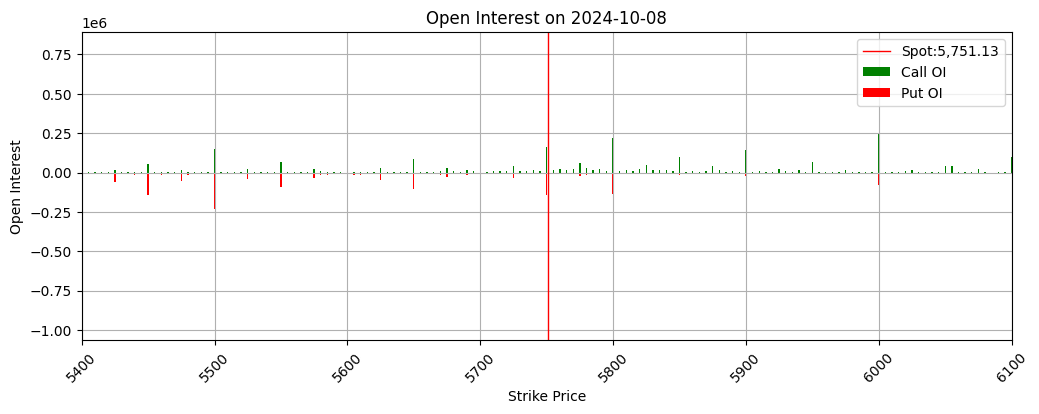

     Strike    CallOI    PutOI
403  6000.0  247589.0  81098.0


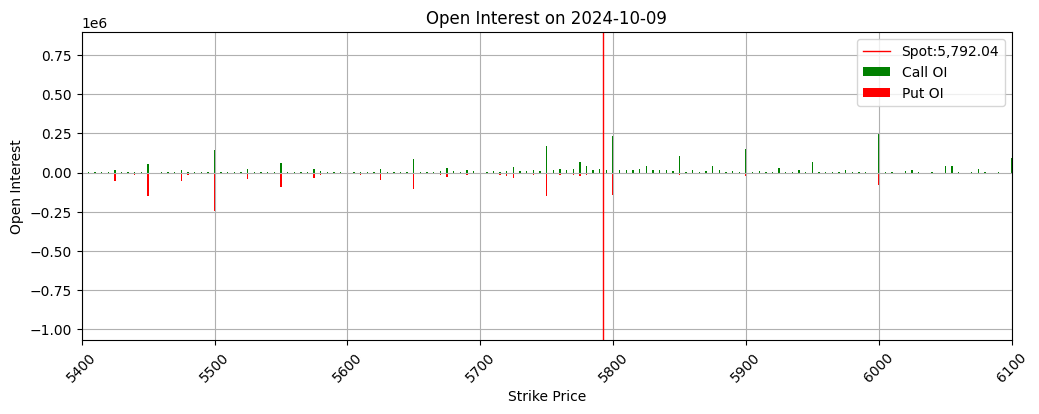

     Strike    CallOI    PutOI
403  6000.0  254271.0  85575.0


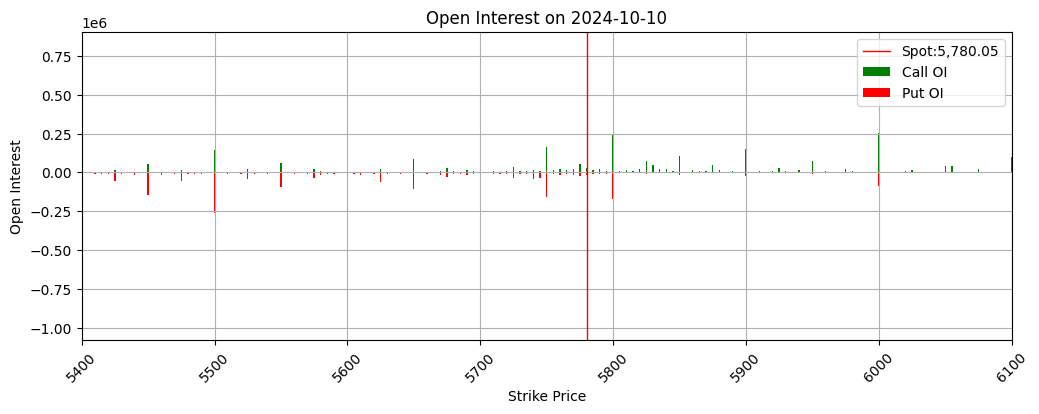

     Strike    CallOI    PutOI
403  6000.0  256833.0  86837.0


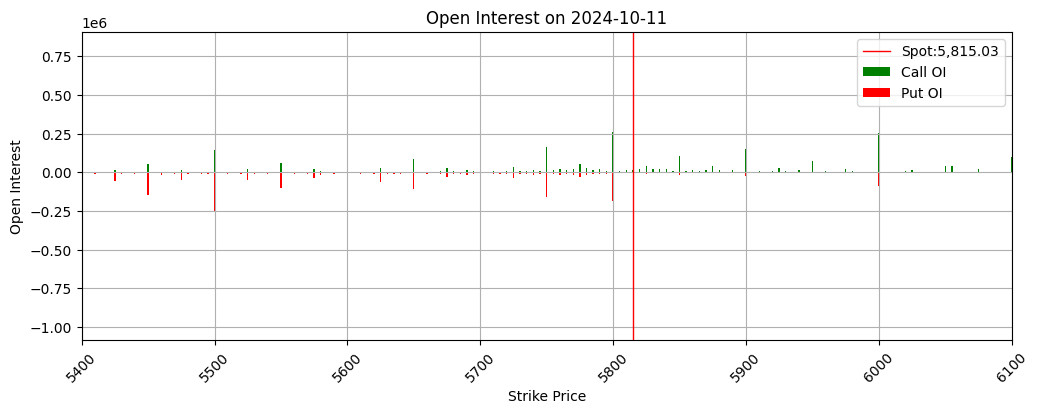

In [65]:
## OI 柱状图

# 每天一个柱状图
now = datetime.now()
time_minus_30 = now - timedelta(days=5)

start_time1 = pd.Timestamp(year=time_minus_30.year, month=time_minus_30.month, day=time_minus_30.day, hour=0, minute=0)
df1 = df[df['Time'] > start_time1]

# 获取所有不同的日期
unique_dates = df1['Time'].unique()

# 逐个日期绘图
for date in unique_dates:
    df_date = df1[df1['Time'] == date]
        
    # 聚合相同 Strike 的 CallOI 和 PutOI
    # df_agg = df_date.groupby('Strike').agg({'CallOI': 'sum', 'PutOI': 'sum'}).reset_index()
    df_agg = df_date.groupby('Strike')[['CallOI', 'PutOI']].sum().reset_index()
    print(df_agg[df_agg["Strike"] == 6000])
    # 绘图
    fig, ax = plt.subplots(figsize=(12, 4))
    
    spotPrice = df_date['DailyClose'].iloc[0]
    ax.axvline(x=spotPrice, color='r', lw=1, label="Spot:" + str("{:,.2f}".format(spotPrice)))

    ax.bar(df_agg['Strike'], df_agg['CallOI'], width=1, color='green', label='Call OI')
    ax.bar(df_agg['Strike'], -df_agg['PutOI'], width=1, color='red', label='Put OI')
    
    plt.xlim([fromStrike-200, toStrike+200])
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Open Interest')
    ax.set_title(f'Open Interest on {date.strftime("%Y-%m-%d")}')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

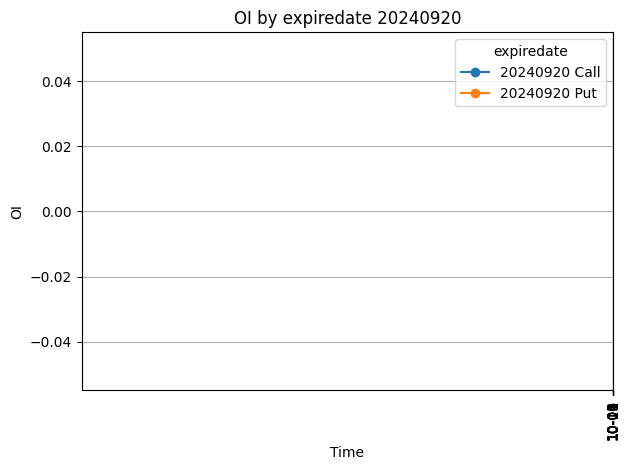

In [66]:
# 特定日期的 OI/Time 折线

expiredate= "20240920" 
unique_dates = df['Time'].unique()
expiredate_df = df[df["ExpiredDate"] == expiredate]
grouped_df = expiredate_df.groupby('Time')[['CallOI', 'PutOI']].sum().reset_index()

plt.plot(grouped_df['Time'], grouped_df['CallOI'], marker='o', label=f'{expiredate} Call')
plt.plot(grouped_df['Time'], -grouped_df['PutOI'], marker='o', label=f'{expiredate} Put')


plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().set_xticks(unique_dates)

plt.xlabel('Time')
plt.ylabel('OI')
plt.title(f'OI by expiredate {expiredate}')
plt.grid(True)
plt.xticks(rotation=90)
plt.legend(title="expiredate")  # 显示图例并设置标题为 "Prices"
plt.tight_layout()
plt.show()


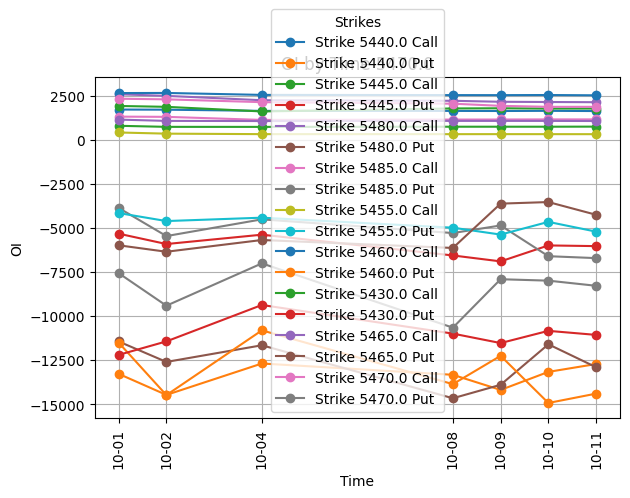

In [67]:
# OI 折线图
strikes = [5440.0, 5445.0, 5480.0, 5485.0, 5455.0, 5460.0, 5430.0, 5465.0, 5470.0]

for strike in strikes:
  price_df = df[df["Strike"] == strike]
  # 选择数值列进行分组求和操作
  grouped_df = price_df.groupby('Time')[['CallOI', 'PutOI']].sum().reset_index()
  # print(strike)
  # print(grouped_df['PutOI'])
  plt.plot(grouped_df['Time'], grouped_df['CallOI'], marker='o', label=f'Strike {strike} Call')
  plt.plot(grouped_df['Time'], -grouped_df['PutOI'], marker='o', label=f'Strike {strike} Put')

# 设置时间轴格式
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # 每天一个刻度
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# 设置时间轴格式，只显示实际有数据的日期
unique_dates = df['Time'].unique()
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().set_xticks(unique_dates)

plt.xlabel('Time')
plt.ylabel('OI')
plt.title(f'OI by Time {strike}')
plt.grid(True)
plt.xticks(rotation=90)
plt.legend(title="Strikes")  # 显示图例并设置标题为 "Prices"
plt.tight_layout()
plt.show()

In [68]:
## 当天 Vol - OI 绝对值最大的5个 Strike
time_minus_30 = now - timedelta(days=5)

start_time1 = pd.Timestamp(year=time_minus_30.year, month=time_minus_30.month, day=time_minus_30.day, hour=0, minute=0)
df1 = df[df['Time'] > start_time1]

# 获取所有不同的日期
unique_dates = df1['Time'].unique()

# 逐个日期绘图
for date in unique_dates:
  df_date = df1[df1['Time'] == date]
  # 找到GEX绝对值最大的5个strike
  grouped_df = df_date.groupby('Strike')[['Call-Vol-OI', 'Put-Vol-OI']].sum().reset_index()  
  top_4_put_strikes = grouped_df.iloc[(grouped_df['Put-Vol-OI']).nlargest(5).index].copy()
  top_4_call_strikes = grouped_df.iloc[(grouped_df['Call-Vol-OI']).nlargest(5).index].copy()
  # 提取不重复的 Strike 值
  call_strike_set = set(top_4_call_strikes['Strike'])
  put_strike_set = set(top_4_put_strikes['Strike'])
  # 找出并集
  merged_set = call_strike_set.union(put_strike_set)
  # 找出不重复的值
  unique_strikes = list(merged_set)     # 在 Python 中，将集合转换为列表会自动去除重复值

  print(date)
  selected_columns = ['Strike', 'Call-Vol-OI']
  print(top_4_call_strikes[selected_columns].to_string(index=False))
  selected_columns1 = ['Strike', 'Put-Vol-OI']
  print(top_4_put_strikes[selected_columns1].to_string(index=False))
  print(unique_strikes)
  

2024-10-08 00:00:00
 Strike  Call-Vol-OI
 5755.0      72872.0
 5760.0      60194.0
 5745.0      57885.0
 5740.0      50265.0
 5765.0      39609.0
 Strike  Put-Vol-OI
 5720.0     53862.0
 5730.0     48088.0
 5715.0     46407.0
 5735.0     43041.0
 5740.0     39064.0
[5760.0, 5730.0, 5765.0, 5735.0, 5740.0, 5745.0, 5715.0, 5720.0, 5755.0]
2024-10-09 00:00:00
 Strike  Call-Vol-OI
 5790.0      87004.0
 5795.0      77483.0
 5785.0      70504.0
 5805.0      47888.0
 5830.0      40029.0
 Strike  Put-Vol-OI
 5740.0     56588.0
 5745.0     55031.0
 5770.0     40122.0
 5780.0     39740.0
 5760.0     36330.0
[5760.0, 5795.0, 5830.0, 5770.0, 5740.0, 5805.0, 5745.0, 5780.0, 5785.0, 5790.0]
2024-10-10 00:00:00
 Strike  Call-Vol-OI
 5785.0      61145.0
 5780.0      60365.0
 5790.0      51051.0
 5795.0      45644.0
 5805.0      44113.0
 Strike  Put-Vol-OI
 5770.0     56903.0
 5760.0     50166.0
 5765.0     46262.0
 5775.0     36694.0
 5780.0     32018.0
[5760.0, 5795.0, 5765.0, 5770.0, 5805.0, 5775.0,

[]


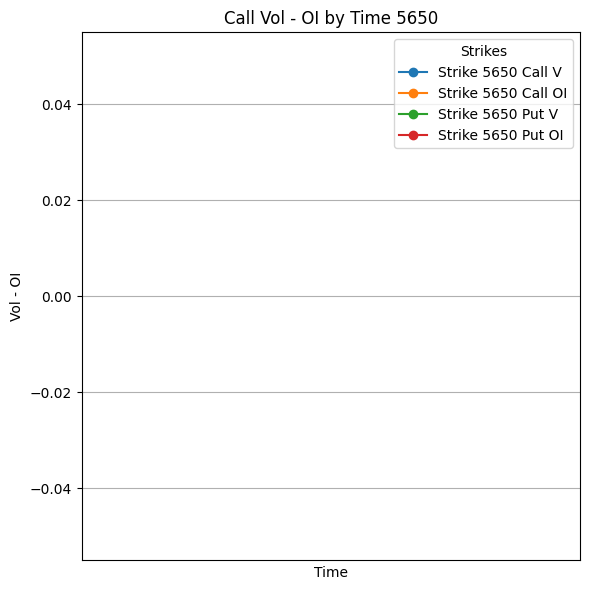

In [69]:
# OI and Volume 折线图, put的 OI Vol 是负值
# 每个 strike 一个图
strikes =  [5650]

for strike in strikes:
  price_df = df[df["Strike"] == strike]
  price_df = price_df[price_df["ExpiredDate"] == "20240919"]
  
  # 选择数值列进行分组求和操作
  grouped_df = price_df.groupby('Time')[['CallOI', 'PutOI', 'CallVol', 'PutVol', 'Call-Vol-OI', 'Put-Vol-OI']].sum().reset_index()
  # print(grouped_df)

  # 设置时间轴格式，只显示实际有数据的日期
  unique_dates2 = grouped_df['Time']
  # 创建索引以保证x轴间距相等
  indices2 = np.arange(len(unique_dates2))
  print(indices2)

  plt.figure(figsize=(6, 6))  # 设置图表大小 (宽度, 高度)
  plt.grid()
  plt.plot(indices2, grouped_df['CallVol'], marker='o', label=f'Strike {strike} Call V')
  plt.plot(indices2, grouped_df['CallOI'], marker='o', label=f'Strike {strike} Call OI')
  plt.plot(indices2, -grouped_df['PutVol'], marker='o', label=f'Strike {strike} Put V')
  plt.plot(indices2, -grouped_df['PutOI'], marker='o', label=f'Strike {strike} Put OI')  
  
  # 将x轴刻度标签设置为日期
  plt.xticks(indices2, unique_dates2.dt.strftime('%Y-%m-%d'))
 
  plt.xlabel('Time')
  plt.ylabel('Vol - OI')
  plt.title(f'Call Vol - OI by Time {strike}')
  plt.grid(True)
  plt.xticks(rotation=90)
  plt.legend(title="Strikes")  # 显示图例并设置标题为 "Prices"
  plt.tight_layout()
  plt.show()
  

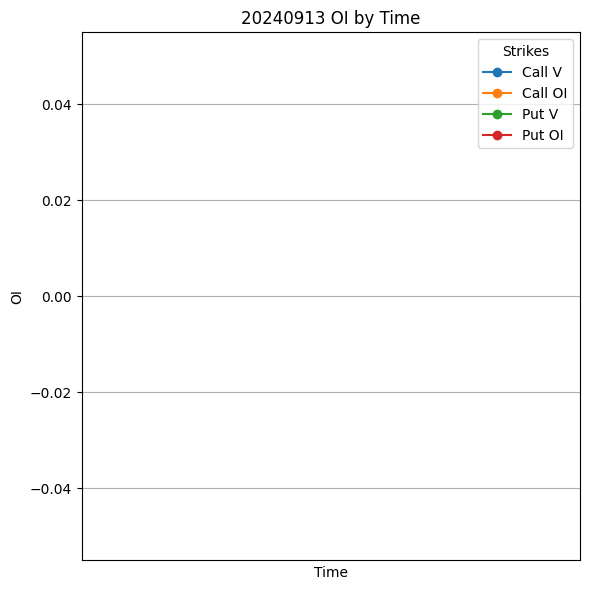

In [70]:
# 特定到期日 OI/Time

expiredDate1 = "20240913"
strike1 = 5510

df3 = df[df["ExpiredDate"] == expiredDate1]
df3= df3[df3["Strike"] == strike1]
grouped_df = df3.groupby('Time')[['CallOI', 'PutOI', 'CallVol', 'PutVol']].sum().reset_index()
plt.figure(figsize=(6, 6))  # 设置图表大小 (宽度, 高度)
plt.grid()
plt.plot(grouped_df['Time'], grouped_df['CallVol'], marker='o', label=f'Call V')
plt.plot(grouped_df['Time'], grouped_df['CallOI'], marker='o', label=f'Call OI')
plt.plot(grouped_df['Time'], -grouped_df['PutVol'], marker='o', label=f'Put V')
plt.plot(grouped_df['Time'], -grouped_df['PutOI'], marker='o', label=f'Put OI')
# 设置时间轴格式
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # 每天一个刻度
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# 设置时间轴格式，只显示实际有数据的日期
unique_dates = df3['Time'].unique()
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().set_xticks(unique_dates)

plt.xlabel('Time')
plt.ylabel('OI')
plt.title(f'{expiredDate1} OI by Time')
plt.grid(True)
plt.xticks(rotation=90)
plt.legend(title="Strikes")  # 显示图例并设置标题为 "Prices"
plt.tight_layout()
plt.show()

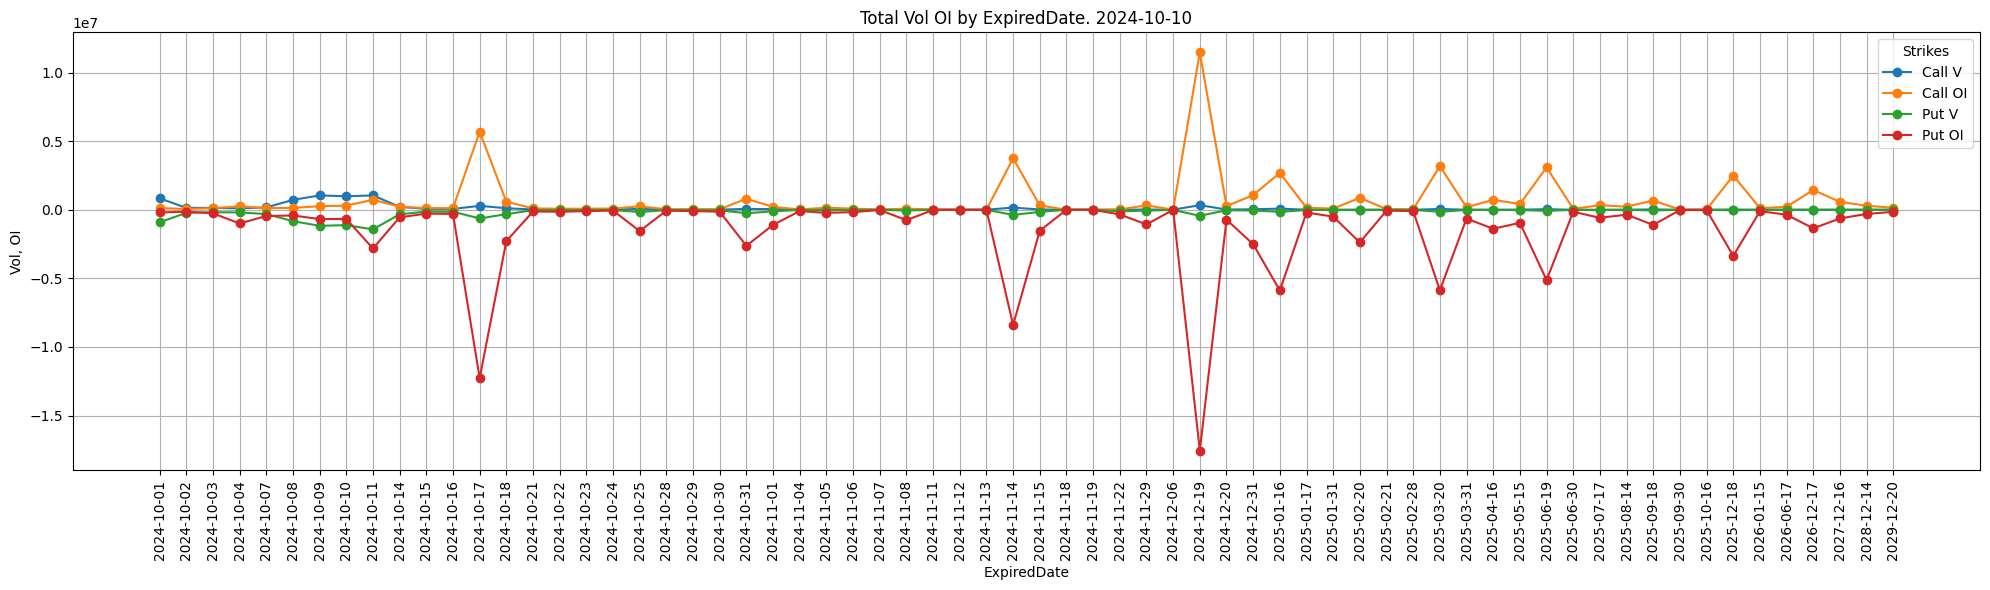

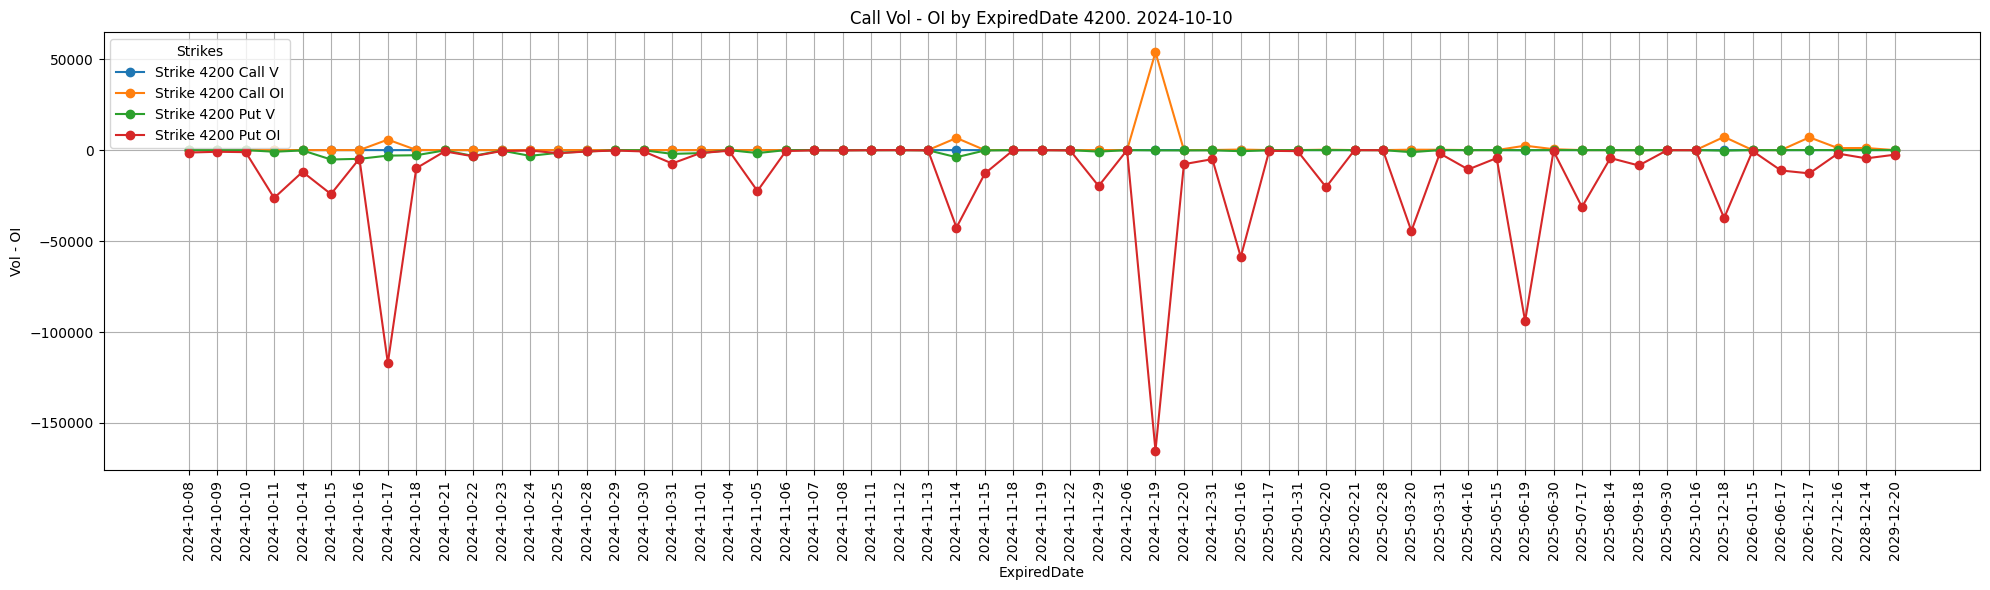

In [71]:
# 某些 OI and Volume 随到期日的分布折线图, put的 OI Vol 是负值
# 当天的 OI，当天和昨天的 Vol

strikes = [4200]

# 总 OI 分布
grouped_df1 = df.groupby('ExpiredDate1')[['CallOI', 'PutOI', 'CallVol', 'PutVol']].sum().reset_index()  
plt.figure(figsize=(20, 6))  # 设置图表大小 (宽度, 高度)
plt.grid()
# 设置时间轴格式，只显示实际有数据的日期
unique_dates = grouped_df1['ExpiredDate1']
# 创建索引以保证x轴间距相等
indices = np.arange(len(unique_dates))
plt.plot(indices, grouped_df1['CallVol'], marker='o', label=f'Call V')
plt.plot(indices, grouped_df1['CallOI'], marker='o', label=f'Call OI')
plt.plot(indices, -grouped_df1['PutVol'], marker='o', label=f'Put V')
plt.plot(indices, -grouped_df1['PutOI'], marker='o', label=f'Put OI')

# 将x轴刻度标签设置为日期
plt.xticks(indices, unique_dates.dt.strftime('%Y-%m-%d'))

plt.xlabel('ExpiredDate')
plt.ylabel('Vol, OI')
plt.title(f'Total Vol OI by ExpiredDate. {start_time.strftime("%Y-%m-%d")}')
plt.grid(True)
plt.xticks(rotation=90)
plt.legend(title="Strikes")  # 显示图例并设置标题为 "Prices"
plt.tight_layout()
plt.show()


# endof_expireddatee = pd.Timestamp(year=2026, month=6, day=18, hour=0, minute=0)
# endof_expireddatee = pd.Timestamp(year=2024, month=10, day=1, hour=0, minute=0)

# df1= df1[df1['ExpiredDate1'] < endof_expireddatee]
# df2= df2[df2['ExpiredDate1'] < endof_expireddatee]
# print(df1[(df1['ExpiredDate'] == '20240719') & (df1['Strike'] == 5500)])

for strike in strikes:
  price_df = df1[df1["Strike"] == strike]  
  # 选择数值列进行分组求和操作
  grouped_df2 = price_df.groupby('ExpiredDate1')[['CallOI', 'PutOI', 'CallVol', 'PutVol']].sum().reset_index()  
  
  # 设置时间轴格式，只显示实际有数据的日期
  unique_dates2 = grouped_df2['ExpiredDate1']
  # 创建索引以保证x轴间距相等
  indices2 = np.arange(len(unique_dates2))

  plt.figure(figsize=(20, 6))  # 设置图表大小 (宽度, 高度)
  plt.grid()
  plt.plot(indices2, grouped_df2['CallVol'], marker='o', label=f'Strike {strike} Call V')
  plt.plot(indices2, grouped_df2['CallOI'], marker='o', label=f'Strike {strike} Call OI')
  plt.plot(indices2, -grouped_df2['PutVol'], marker='o', label=f'Strike {strike} Put V')
  plt.plot(indices2, -grouped_df2['PutOI'], marker='o', label=f'Strike {strike} Put OI')

  # 将x轴刻度标签设置为日期
  plt.xticks(indices2, unique_dates2.dt.strftime('%Y-%m-%d'))

  plt.xlabel('ExpiredDate')
  plt.ylabel('Vol - OI')
  plt.title(f'Call Vol - OI by ExpiredDate {strike}. {start_time.strftime("%Y-%m-%d")}')
  plt.grid(True)
  plt.xticks(rotation=90)
  plt.legend(title="Strikes")  # 显示图例并设置标题为 "Prices"
  plt.tight_layout()
  plt.show()

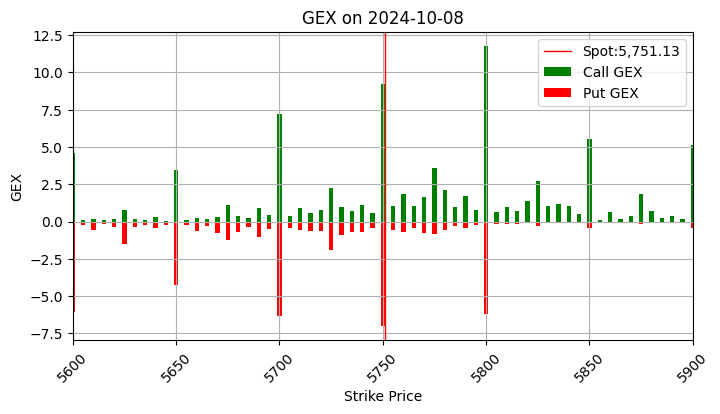

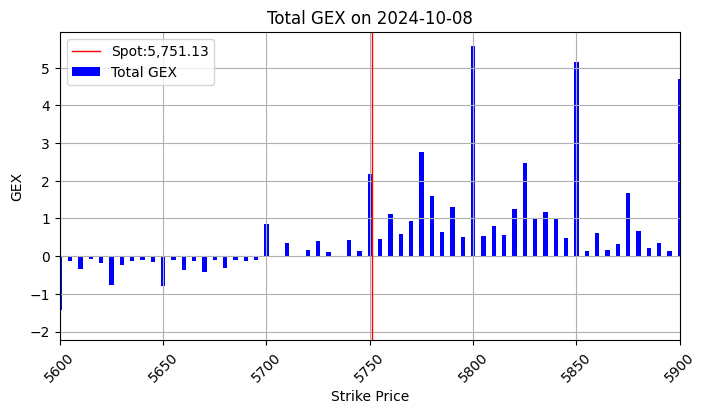

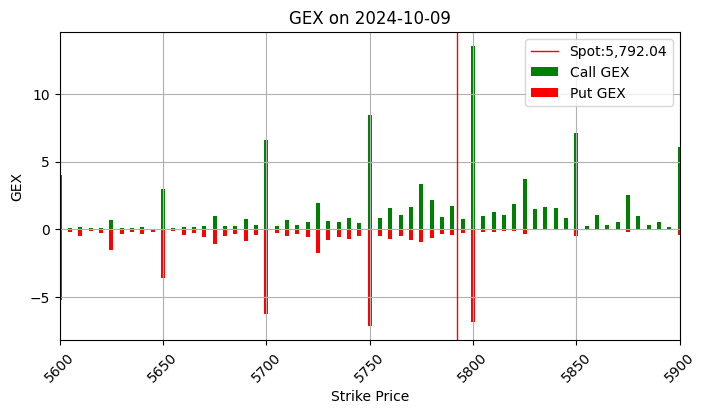

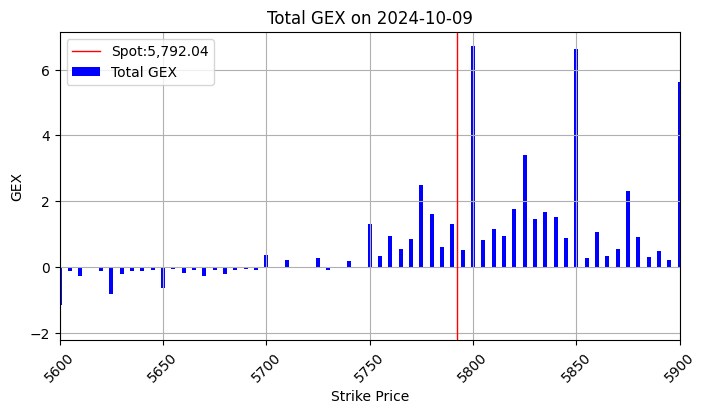

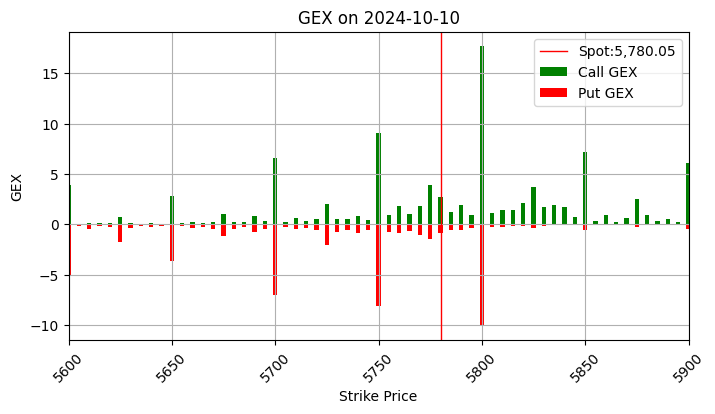

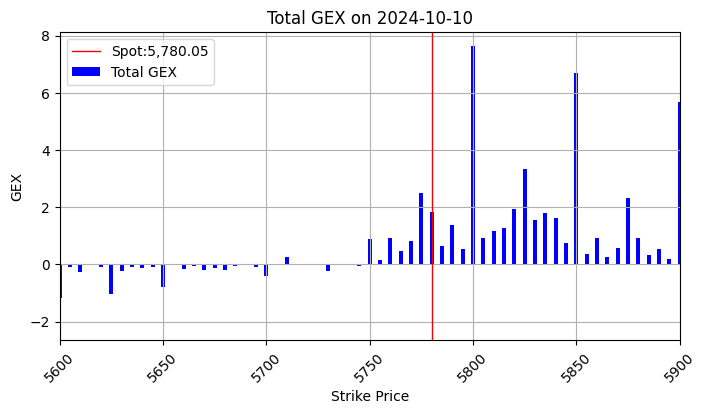

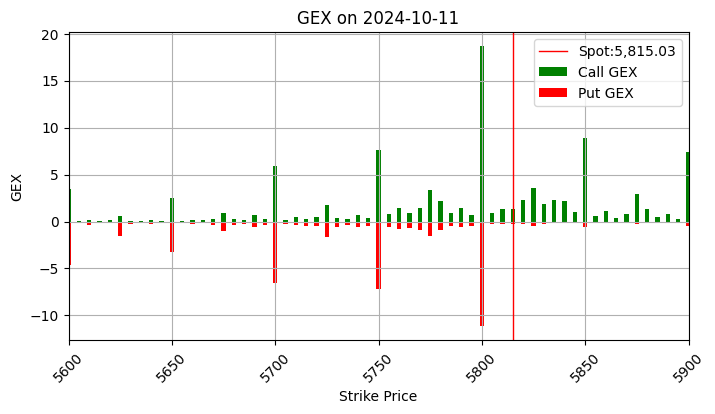

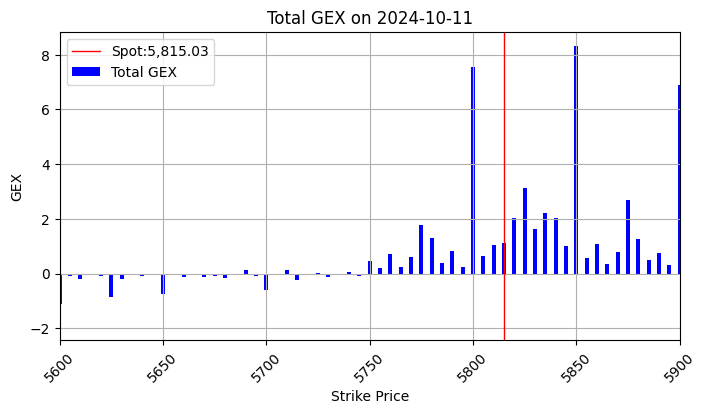

In [72]:
## GEX 柱状图

# 每天一个柱状图
now = datetime.now()
time_minus_30 = now - timedelta(days=5)

start_time = pd.Timestamp(year=time_minus_30.year, month=time_minus_30.month, day=time_minus_30.day, hour=0, minute=0)
df2 = df[df['Time'] > start_time]

## 下一周的 GEX
# df2 = df[df['Time'] > now]
# nextweek = pd.Timestamp(year=time_minus_30.year, month=7, day=20, hour=0, minute=0)
# df2= df2[df2['ExpiredDate'] <  nextweek]

# 获取所有不同的日期
unique_dates2 = df2['Time'].unique()

# 逐个日期绘图
for date in unique_dates2:
    df_date = df2[df2['Time'] == date]
    
    # 聚合相同 Strike 的 CallOI 和 PutOI
    # df_agg = df_date.groupby('Strike').agg({'CallOI': 'sum', 'PutOI': 'sum'}).reset_index()
    df_agg2 = df_date.groupby('Strike')[['CallGEX', 'PutGEX', 'TotalGEX']].sum().reset_index()
    # 绘图
    fig, ax = plt.subplots(figsize=(8, 4))
    
    spotPrice = df_date['DailyClose'].iloc[0]
    ax.axvline(x=spotPrice, color='r', lw=1, label="Spot:" + str("{:,.2f}".format(spotPrice)))

    ax.bar(df_agg2['Strike'], df_agg2['CallGEX'], width=2, color='green', label='Call GEX')
    ax.bar(df_agg2['Strike'], df_agg2['PutGEX'], width=2, color='red', label='Put GEX')
    
    plt.xlim([fromStrike, toStrike])
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('GEX')
    ax.set_title(f'GEX on {date.strftime("%Y-%m-%d")}')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Total GEX
    fig, ax = plt.subplots(figsize=(8, 4))    
    
    spotPrice = df_date['DailyClose'].iloc[0]
    ax.axvline(x=spotPrice, color='r', lw=1, label="Spot:" + str("{:,.2f}".format(spotPrice)))

    ax.bar(df_agg2['Strike'], df_agg2['TotalGEX'], width=2, color='blue', label='Total GEX')
    
    plt.xlim([fromStrike, toStrike])
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('GEX')
    ax.set_title(f'Total GEX on {date.strftime("%Y-%m-%d")}')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

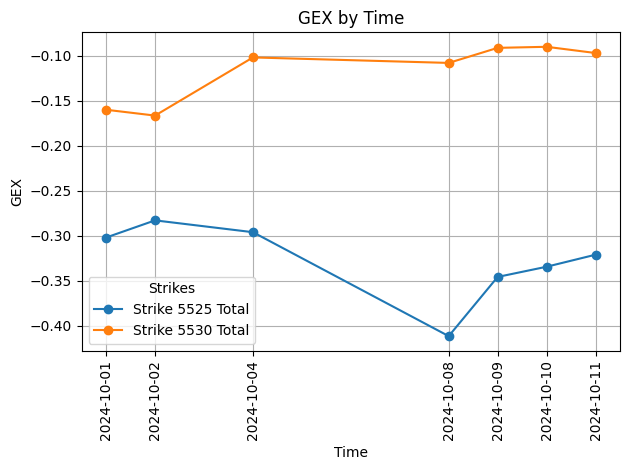

In [73]:
# GEX 折线图：某些 Strike 的 Total GEX随时间的变化
strikes = [5525, 5530] 

for strike in strikes:
  price_df = df[df["Strike"] == strike]
  # 选择数值列进行分组求和操作
  grouped_df = price_df.groupby('Time')[['CallGEX', 'PutGEX', 'TotalGEX']].sum().reset_index()
  # plt.plot(grouped_df['Time'], grouped_df['CallGEX'], marker='o', label=f'Strike {strike} Call')
  # plt.plot(grouped_df['Time'], -grouped_df['PutGEX'], marker='o', label=f'Strike {strike} Put')
  plt.plot(grouped_df['Time'], grouped_df['TotalGEX'], marker='o', label=f'Strike {strike} Total')

# 设置时间轴格式
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # 每天一个刻度
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# 设置时间轴格式，只显示实际有数据的日期
unique_dates = df['Time'].unique()
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().set_xticks(unique_dates)

plt.xlabel('Time')
plt.ylabel('GEX')
plt.title('GEX by Time')
plt.grid(True)
plt.xticks(rotation=90)
plt.legend(title="Strikes")  # 显示图例并设置标题为 "Prices"
plt.tight_layout()
plt.show()